# Lab 9. HITS Algorithm

Given an adjacency matrix of a graph, HITS computes the hub and authority score vectors which can be used for ranking nodes in the graph. 

##### Problem definition of HITS
* **Input**: adjacency matrix $\mathbf{A}\in \mathbb{R}^{n \times n}$ of a graph $G=(V, E)$
* **Output**: hub score vector $\mathbf{h} \in \mathbb{R}^{n}$, and authority score vector $\mathbf{a} \in \mathbb{R}^{n}$ such that

    - $\mathbf{h} = \mathbf{A}\mathbf{a}$
    - $\mathbf{a} = \mathbf{A}^{\top}\mathbf{h}$

* The above equations are called the equations for HITS.

Note that HITS does not require the row-normalized adjacency matrix. 

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix, find
import networkx as nx

At first load dataset from `data_1`. This is small dataset, just to test your implementation.

In [2]:
def load_data(path):
    edges = np.loadtxt(path+'/edges.tsv', dtype=int)
    node_labels = pd.read_csv(path+'/node_labels.tsv', sep="\t")
    n = int(np.amax(edges[:, 0:2])) + 1
    A = csr_matrix((edges[:, 2], (edges[:, 0], edges[:, 1])), shape=(n, n), dtype=float)
    AT = A.T
    G = nx.from_scipy_sparse_matrix(A)
    return A, AT, G, node_labels
A, AT, G, labels = load_data('data_1')

Let's consider what do we have

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


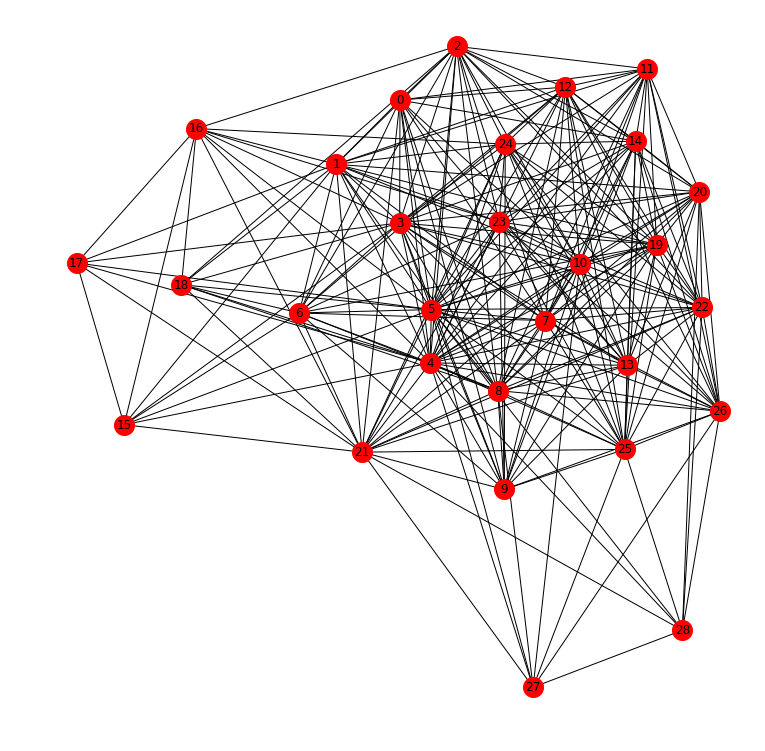

In [3]:
gpos = nx.spring_layout(G)
plt.figure(figsize=(10,10))
nx.draw(G, gpos, with_labels=True, node_size=400)

In [4]:
print("The number n of nodes: {}".format(A.shape[0]))
print("The number m of edges: {}".format(A.nnz))

The number n of nodes: 29
The number m of edges: 376


## Implementation step

The hub and authority score vectors, $\mathbf{h}$ and $\mathbf{a}$, are obtained by iteratively computing the equations for HITS.   
Note that for each iteration, we need to L2-normalize the vectors $\mathbf{h}$ and $\mathbf{a}$.
The following pseudo-code represents the iterative algorithm for HITS. 

<img src="./iterative-algorithm-hits.png" width="400">

Implement the iterative algorithm in Python. 

In [5]:
from numpy import linalg as LA
def HITS(A, AT, epsilon=1e-9, maxIters=100):
    '''
    Iterate the HITS equation to obatin the hub & authority score vectors

    inputs:
        epsilon: float
            the error tolerance of the iteration
        maxIters: int
            the maximum number of iterations

    outputs:
        h: np.ndarray (n x 1 vector)
            the final hub score vector
        a: np.ndarray (n x 1 vector)
            the final authority score vector
        h_residuals: list
            the list of hub residuals over the iteration
        a_residuals: list
            the list of authority residuals over the iteration

    '''
    n = A.shape[0]     # number of nodes
    m = A.nnz          # number of edges
    
    h = np.ones(n)
    a = np.ones(n)
    h_residuals = []
    a_residuals = []
    
    for i in range(maxIters):
        new_hubs = A * a
        new_auth = A.T * h
        
        new_hubs = new_hubs/LA.norm(new_hubs)
        new_auth = new_auth/LA.norm(new_auth)
        
        h_residuals.append(abs(sum(new_hubs - h)))
        a_residuals.append(abs(sum(new_auth - a)))
        
        h = new_hubs
        a = new_auth
        
        if h_residuals[-1] < epsilon and a_residuals[-1] < epsilon:
            break

    return h, a, h_residuals, a_residuals

Let's check the implementation is correctly performed. 
We will briefly check each personalized ranking result using `pandas`. 
See the following code where a seed node is given. 
Note that the given seed node should have a high ranking score. 

In [6]:
def rank_nodes_k(ranking_scores,node_labels, topk=-1):
    '''
    Rank nodes in the order of given ranking scores. 
    This function reports top-k rankings. 

    inputs:
        ranking_scores: np.ndarray
            ranking score vector
        topk: int
            top-k ranking parameter, default is -1 indicating report all ranks
    '''
    sorted_nodes = np.flipud(np.argsort(ranking_scores)) # argsort in the descending order
    sorted_scores = ranking_scores[sorted_nodes]         # sort the ranking scores
    ranks = range(1, A.shape[0]+1) # 0~n-1

    result_labels = node_labels.iloc[sorted_nodes][0:topk]
    result_labels.insert(0, "rank", ranks[0:topk])
    result_labels["score"] = sorted_scores[0:topk]
    result_labels.reset_index(drop = True, inplace = True)
    return result_labels

In [7]:
### RUN THIS CELL ###

h, a, h_residuals, a_residuals = HITS(A, AT, epsilon=1e-9, maxIters=100)

print("Top-5 rankings based on the hub score vector:")
display(rank_nodes_k(h,labels, 5))

print("Top-5 rankings based on the authority score vector")
display(rank_nodes_k(a,labels, 5))

### AND CHECK WITH PRECOMPUTED RESULT OF NEXT CELL ###

Top-5 rankings based on the hub score vector:


,rank,node_id,label,score
0,1,4,male_jacob,0.320863
1,2,5,male_elijah,0.317454
2,3,3,male_benjamin,0.293383
3,4,2,male_william,0.224871
4,5,21,male_matthew,0.219779


Top-5 rankings based on the authority score vector


,rank,node_id,label,score
0,1,7,female_emma,0.269209
1,2,8,female_olivia,0.262543
2,3,10,female_isabella,0.260004
3,4,13,female_amelia,0.249306
4,5,11,female_sophia,0.242907


Check your results with my precomputed results

In [8]:
h, a, h_residuals, a_residuals = HITS(A, AT, epsilon=1e-9, maxIters=100)

print("Top-5 rankings based on the hub score vector:")
display(rank_nodes_k(h,labels, 5))

print("Top-5 rankings based on the authority score vector")
display(rank_nodes_k(a,labels, 5))

Top-5 rankings based on the hub score vector:


,rank,node_id,label,score
0,1,4,male_jacob,0.320863
1,2,5,male_elijah,0.317454
2,3,3,male_benjamin,0.293383
3,4,2,male_william,0.224871
4,5,21,male_matthew,0.219779


Top-5 rankings based on the authority score vector


,rank,node_id,label,score
0,1,7,female_emma,0.269209
1,2,8,female_olivia,0.262543
2,3,10,female_isabella,0.260004
3,4,13,female_amelia,0.249306
4,5,11,female_sophia,0.242907


## Validation step

Validate the implementation of HITS. Similarly to PageRank, check if the residuals of the 
iterative algorithm monotonically decrease, and compare between the exact and iterative solutions of HITS.



In [9]:
def plot_residuals(residuals, title):
    plt.semilogy(residuals, marker='o', markersize=5)
    plt.title(title)
    plt.ylim(bottom=1e-10, top=1e1)
    plt.ylabel('Residual')
    plt.xlabel('# of iterations')
    plt.grid(True)
    plt.show()

### Residuals monotonically decrease

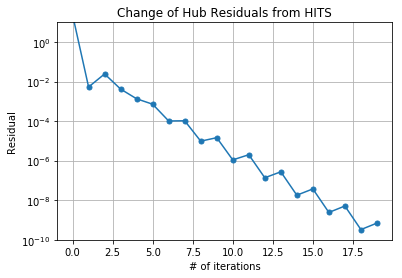

In [10]:
### RUN THIS CELL ###

plot_residuals(h_residuals, 'Change of Hub Residuals from HITS')

### AND CHECK WITH PRECOMPUTED RESULT OF NEXT CELL ###

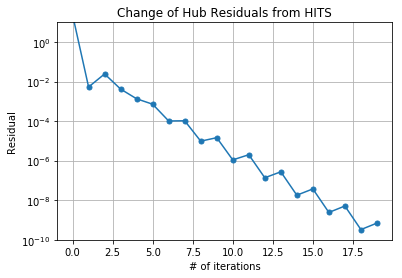

In [11]:
plot_residuals(h_residuals, 'Change of Hub Residuals from HITS')

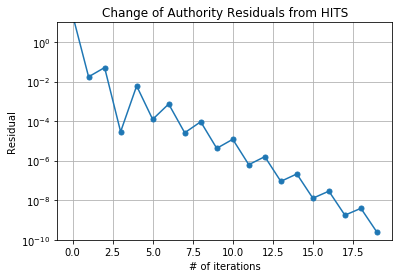

In [12]:
### RUN THIS CELL ###

plot_residuals(a_residuals, 'Change of Authority Residuals from HITS')

### AND CHECK WITH PRECOMPUTED RESULT OF NEXT CELL ###

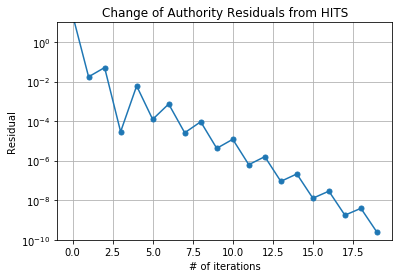

In [13]:
plot_residuals(a_residuals, 'Change of Authority Residuals from HITS')

### Check if the iterative solution is equal to the exact solution of HITS

We can directly compute the hub ans authority score vectors of HITS as follows:
* The hub score vector $\mathbf{h}$ is the principle eigenvector of $\mathbf{A}\mathbf{A}^{\top}$.
* The authority score vector $\mathbf{a}$ is the principle eigenvector of $\mathbf{A}^{\top}\mathbf{A}$.

The principle eigenvector of a matrix is an eigenvector of the largest eigenvalue. 
Suppose the Singular Value Decomposition (SVD) of the adjacency matrix is $\mathbf{A}=\mathbf{U}\mathbf{S}\mathbf{V}^{\top}$. Then,
* $\mathbf{h}$ is the first (most left) vector of $\mathbf{U}$. 
* $\mathbf{a}$ is the first (most left) vector of $\mathbf{V}$.

We will not describe the detailed proofs for the above statements, but we can use them as the exact solutions for the hub and authority score vectors. 

We will implement the following function to compute the exact solutions. 
Note that since the adjacency matrix $\mathbf{A}$ is a sparse matrix, we will use `svds` (sparse SVD) in `scipy`.
* `svds`: this performs SVD on a sparse matrix
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

In [14]:
def exact_HITS(A):
    from scipy.sparse.linalg import svds
    '''
    Compute the exact hub & authority score vectors from the closed form

    outputs:
        h: np.ndarray (n x 1 vector)
            the final hub score vector
        a: np.ndarray (n x 1 vector)
            the final authority score vector
    '''
    h, s, a = svds(A, k=1)

    h = np.asarray(h).flatten()   
    a = np.asarray(a).flatten()

    h = h * np.sign(h)
    h = h / np.linalg.norm(h, 2)
    a = a * np.sign(a)
    a = a / np.linalg.norm(a, 2)

    return h, a

#### Errors 
Error between exact and iterative hub scores: 1.275379e-10

Error between exact and iterative authority scores: 4.813523e-11

In [15]:
### RUN THIS CELL AND COMPARE RESULTS ###

h_exact, a_exact = exact_HITS(A)
h_error = np.linalg.norm(h_exact - h, 1)
print("Error between exact and iterative hub scores: {:e}".format(h_error))

a_error = np.linalg.norm(a_exact - a, 1)
print("Error between exact and iterative authority scores: {:e}".format(a_error))

Error between exact and iterative hub scores: 1.288447e-09
Error between exact and iterative authority scores: 2.577574e-09


### Big dataset

In [16]:
A, AT, G, labels = load_data('data_2')

In [17]:
### RUN THIS CELL ###

h, a, h_residuals, a_residuals = HITS(A, AT, epsilon=1e-9, maxIters=100)

print("Top-10 rankings based on the hub score vector:")
display(rank_nodes_k(h,labels, 10))

print("Top-10 rankings based on the authority score vector")
display(rank_nodes_k(a,labels, 10))

### AND CHECK WITH PRECOMPUTED RESULT OF NEXT CELL ###

Top-10 rankings based on the hub score vector:


,rank,node_id,address,score
0,1,141,no.address@enron.com,0.464946
1,2,371,40enron@enron.com,0.301402
2,3,733,tana.jones@enron.com,0.155692
3,4,671,sara.shackleton@enron.com,0.135909
4,5,105,steven.kean@enron.com,0.124172
5,6,1328,mark.haedicke@enron.com,0.114921
6,7,90,jeff.dasovich@enron.com,0.110499
7,8,1624,mark.taylor@enron.com,0.108638
8,9,2,john.lavorato@enron.com,0.107663
9,10,156,louise.kitchen@enron.com,0.105987


Top-10 rankings based on the authority score vector


,rank,node_id,address,score
0,1,156,louise.kitchen@enron.com,0.196387
1,2,2,john.lavorato@enron.com,0.149168
2,3,228,greg.whalley@enron.com,0.137076
3,4,97,sally.beck@enron.com,0.126122
4,5,733,tana.jones@enron.com,0.125953
5,6,1,tim.belden@enron.com,0.120326
6,7,1624,mark.taylor@enron.com,0.119657
7,8,1136,elizabeth.sager@enron.com,0.108948
8,9,671,sara.shackleton@enron.com,0.108918
9,10,136,richard.shapiro@enron.com,0.103350


In [18]:
h, a, h_residuals, a_residuals = HITS(A, AT, epsilon=1e-9, maxIters=100)

print("Top-10 rankings based on the hub score vector:")
display(rank_nodes_k(h,labels, 10))

print("Top-10 rankings based on the authority score vector")
display(rank_nodes_k(a,labels, 10))

Top-10 rankings based on the hub score vector:


,rank,node_id,address,score
0,1,141,no.address@enron.com,0.464946
1,2,371,40enron@enron.com,0.301402
2,3,733,tana.jones@enron.com,0.155692
3,4,671,sara.shackleton@enron.com,0.135909
4,5,105,steven.kean@enron.com,0.124172
5,6,1328,mark.haedicke@enron.com,0.114921
6,7,90,jeff.dasovich@enron.com,0.110499
7,8,1624,mark.taylor@enron.com,0.108638
8,9,2,john.lavorato@enron.com,0.107663
9,10,156,louise.kitchen@enron.com,0.105987


Top-10 rankings based on the authority score vector


,rank,node_id,address,score
0,1,156,louise.kitchen@enron.com,0.196387
1,2,2,john.lavorato@enron.com,0.149168
2,3,228,greg.whalley@enron.com,0.137076
3,4,97,sally.beck@enron.com,0.126122
4,5,733,tana.jones@enron.com,0.125953
5,6,1,tim.belden@enron.com,0.120326
6,7,1624,mark.taylor@enron.com,0.119657
7,8,1136,elizabeth.sager@enron.com,0.108948
8,9,671,sara.shackleton@enron.com,0.108918
9,10,136,richard.shapiro@enron.com,0.103350


#### Run next cells for self check

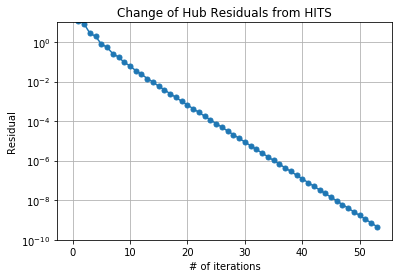

In [19]:
plot_residuals(h_residuals, 'Change of Hub Residuals from HITS')

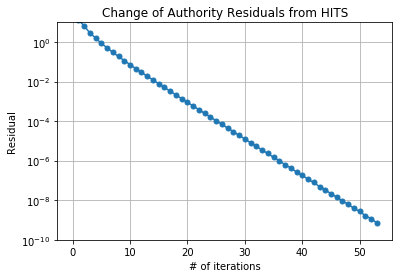

In [20]:
plot_residuals(a_residuals, 'Change of Authority Residuals from HITS')

#### Errors
Error between exact and iterative hub scores: 3.545309e-10

Error between exact and iterative authority scores: 4.231717e-10

In [23]:
h_exact, a_exact = exact_HITS(A)
h_error = np.linalg.norm(h_exact - h, 1)
print("Error between exact and iterative hub scores: {:e}".format(h_error))

a_error = np.linalg.norm(a_exact - a, 1)
print("Error between exact and iterative authority scores: {:e}".format(a_error))

Error between exact and iterative hub scores: 7.953395e-10
Error between exact and iterative authority scores: 2.107171e-09


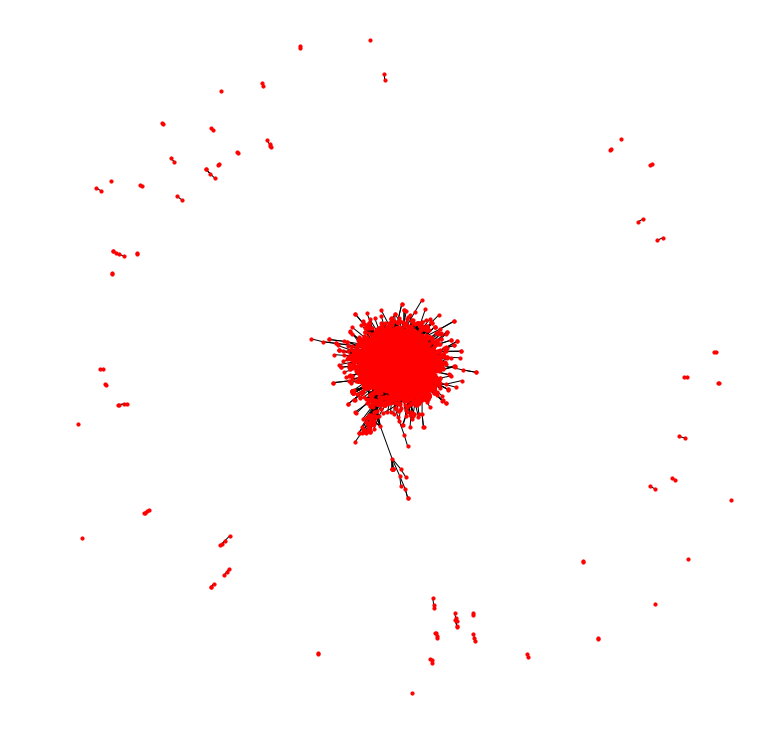

In [22]:
gpos = nx.spring_layout(G)
plt.figure(figsize=(10,10))
nx.draw(G, gpos, node_size=10)